In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import shutil
import io

# Inspect full image archive without extracting all files

In [2]:
zipf = zipfile.ZipFile('Img/img_highres.zip') # not using high-res images to simplify data wrangling

In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'product_name', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=10)

289212


,index,root_path,product_name,filename,path
250974,255901,img_highres,Striped_Shaggy_Knit_Sweater,img_00000014.jpg,img_highres/Striped_Shaggy_Knit_Sweater/img_00...
122107,124372,img_highres,Floral_Lace_Kimono,img_00000025.jpg,img_highres/Floral_Lace_Kimono/img_00000025.jpg
112589,114694,img_highres,Faux_Leather_Skater_Skirt,img_00000072.jpg,img_highres/Faux_Leather_Skater_Skirt/img_0000...
283699,289229,img_highres,Windowpane_Print_Blouse,img_00000016.jpg,img_highres/Windowpane_Print_Blouse/img_000000...
128930,131312,img_highres,Flounced_Sateen_Romper,img_00000022.jpg,img_highres/Flounced_Sateen_Romper/img_0000002...
44791,45633,img_highres,Chiffon-Paneled_High-Slit_Top,img_00000006.jpg,img_highres/Chiffon-Paneled_High-Slit_Top/img_...
222682,227046,img_highres,Scoop_Back_Skater_Dress,img_00000011.jpg,img_highres/Scoop_Back_Skater_Dress/img_000000...
184131,187709,img_highres,Mixed_Print_Maxi_Dress,img_00000003.jpg,img_highres/Mixed_Print_Maxi_Dress/img_0000000...
43413,44227,img_highres,Chenille_Embroidered_Maxi_Dress,img_00000030.jpg,img_highres/Chenille_Embroidered_Maxi_Dress/im...
9703,9924,img_highres,Acid_Wash_-_Skinny_Jeans,img_00000055.jpg,img_highres/Acid_Wash_-_Skinny_Jeans/img_00000...


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 31.22 GB


# Basic EDA

### Number of product types (each image file is a unique product)

In [6]:
# Number of unique products
products = np.unique(df.product_name)
len(products)

5620

In [7]:
def flattenTypes(val):
    lst = val.split('_')
    return lst[-1]

In [8]:
df['product_type'] = df.product_name.apply(flattenTypes)
all_cats = np.unique(df.product_type)
print(len(all_cats))
all_cats

46


array(['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan',
       'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes',
       'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley',
       'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs',
       'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie',
       'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts',
       'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee',
       'Top', 'Trunks', 'Turtleneck'], dtype=object)

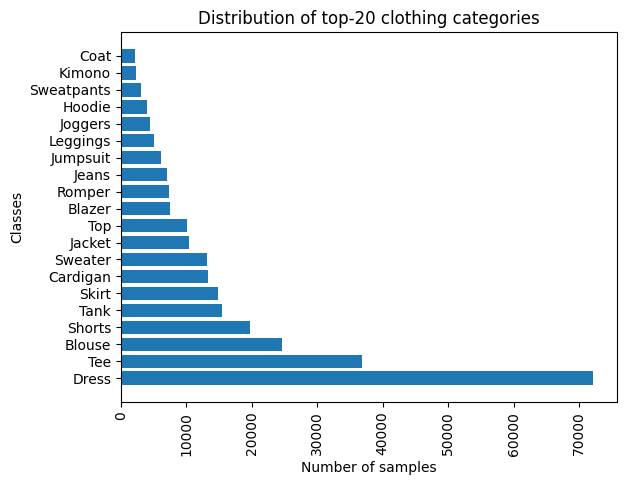

In [9]:
histdata = df.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [10]:
histdata[histdata['root_path'] < 5000][-10:]

,index,root_path,product_name,filename,path
product_type,,,,,
Kaftan,126,126,126,126,126
Peacoat,97,97,97,97,97
Capris,77,77,77,77,77
Onesie,70,70,70,70,70
Caftan,54,54,54,54,54
Gauchos,49,49,49,49,49
Jodhpurs,45,45,45,45,45
Sarong,32,32,32,32,32
Halter,17,17,17,17,17


# Prepare subset of overall data based on specific categories of products

### Sample files in categories

In [11]:
df_all = df
df_all['product_type'] = df_all.product_type.apply(lambda x: 'Long_Leg' if x in ['Jeans', 'Joggers', 'Sweatpants'] else x)
df_all['product_type'] = df_all.product_type.apply(lambda x: 'Long_Sleeve' if x in ['Blouse', 'Sweater', 'Cardigan', 'Hoodie'] else x)

In [12]:
excl = histdata[histdata['root_path'] < 1500]['index'].index.values
excl = np.append(excl, ['Coat', 'Shorts', 'Cutoffs', 'Top', 'Skirt','Blazer', 'Jacket', 'Leggings', 'Jumpsuit', 'Romper', 'Kimono'])
df_all = df_all[df_all.product_type.apply(lambda x: x not in excl)]

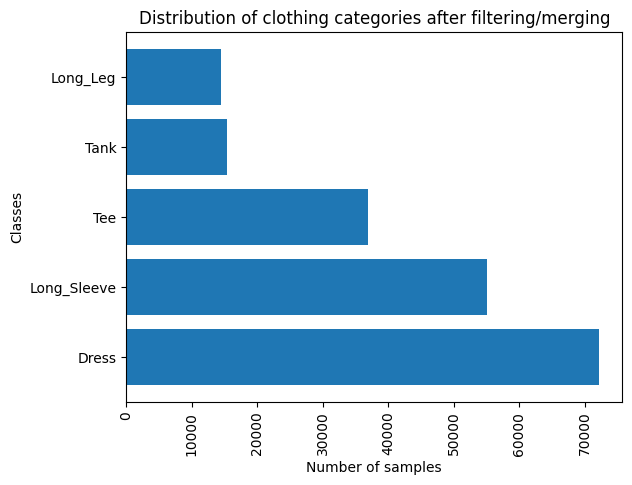

In [13]:
histdata = df_all.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of clothing categories after filtering/merging')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [14]:
cats = np.unique(df_all.product_type)
cats

array(['Dress', 'Long_Leg', 'Long_Sleeve', 'Tank', 'Tee'], dtype=object)

In [15]:
subset = df_all

In [16]:
# numitems is used to determine the category with the smallest number of items
numitems = min(subset.groupby('product_type').count().path)

In [173]:
# then we sample numitems * 90% in each of the cateogries to leave images for later validation and/or testing
subsample = subset.groupby('product_type').sample(n=int(numitems*.9))
len(subsample)

65430

### Load the bounding box data and merge with the file list

In [174]:
# read in the bounding box dataset for all records
f = open('Anno_coarse/list_bbox.txt')
boxes = f.readlines()
boxes = boxes[2:]
boxes = [x.replace('\n', '') for x in boxes]
#boxes = [x.replace('img/', 'img_highres/') for x in boxes]
boxes = [' '.join(x.split()).split() for x in boxes]
df_boxes = pd.DataFrame(boxes, columns=['path', 'x1', 'y1', 'x2', 'y2'])
df_boxes.head()

,path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262


In [175]:
df_boxes.path = df_boxes.path.apply(lambda x: x.replace('img/', 'img_highres/'))

In [176]:
subsample = subsample.merge(df_boxes, how='inner', on='path')

In [177]:
# clean some discovered errors
problem_list = [ 'img_highres/Crinkled_Satin_Halter_Dress/img_00000036.jpg'] # potential DOS bomb
subsample[subsample.path.isin(problem_list)]

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2


In [178]:
subsample = subsample.drop(index=6697)

In [179]:
%%time
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
cnt=0
zipf_lo = zipfile.ZipFile('Img/img.zip')
for file in subsample.path.values:
    if cnt%int((len(subsample)/5))==0:
        print(cnt)
    cnt+=1
    if 'Striped_A-line_Dress' in file:
        continue
    i_lo = Image.open(io.BytesIO(zipf_lo.read(file.replace('img_highres/', 'img/'))))
    i_hi = Image.open(io.BytesIO(zipf.read(file)))
    dims.append([file, *i_lo.size, *i_hi.size])
    
dims_df = pd.DataFrame(dims, columns=['path', 'lo_w', 'lo_h', 'i_w', 'i_h'])

0


/Users/blairjones/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8552 bytes but only got 8356. Skipping tag 37500
  "Possibly corrupt EXIF data.  "


13082
26164
39246
52328
65410
CPU times: user 50.6 s, sys: 12.5 s, total: 1min 3s
Wall time: 1min 48s


In [180]:
subsample = subsample.merge(dims_df, on='path')

In [181]:
%%time
# rescale from lo-res to hi-res x,y coordinates
def rescale_bbox(row):
    x1_old, y1_old, x2_old, y2_old, lo_w, lo_h, hi_w, hi_h = [float(x) for x in row[-8:]]
    x1_new = x1_old/lo_w * hi_w
    y1_new = y1_old/lo_h * hi_h
    x2_new = x2_old/lo_w * hi_w
    y2_new = y2_old/lo_h * hi_h

    row.x1 = int(x1_new)
    row.y1 = int(y1_new)
    row.x2 = int(x2_new)
    row.y2 = int(y2_new)
    
    return row
    
subsample = subsample.apply(rescale_bbox, axis=1)
subsample = subsample.drop(columns=['lo_w', 'lo_h'])

CPU times: user 11.2 s, sys: 166 ms, total: 11.3 s
Wall time: 11.4 s


### Inspect a few sample images and corresponding bounding boxes

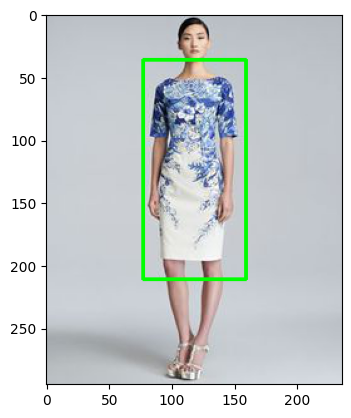

In [182]:
row = subsample.iloc[0]
img = Image.open(io.BytesIO(zipf.read(row[4])))
(x1, y1, x2, y2) = [int(x) for x in row[-6:-2]]
img = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

### Determine dimensions and remove samples not meeting criteria

In [183]:
target_dim = 640.0

In [184]:
# determine which images are outside the range of the 
toobig = subsample[(subsample['i_w'] > target_dim) | (subsample['i_h'] > target_dim)]
len(toobig)

23900

In [252]:
%%time
# Extract all the sample files from the zipped archive to disk
filelist = subsample.path.values
zipf.extractall(path='fashion/', members=filelist)

CPU times: user 45.2 s, sys: 30.4 s, total: 1min 15s
Wall time: 2min 1s


In [254]:
%%time
cnt=0
for file in toobig[:].path.values:
    if cnt%int((len(toobig)/10))==0:
        print(cnt)
    cnt+=1
    
    img = Image.open('fashion/'+file)
    img.thumbnail((target_dim, target_dim)) 
    if 'png' in str(type(img)).lower():
        img = img.convert('RGB')
    img.save('fashion/'+file, 'JPEG', optimize=True)
    
    h_new = np.array(img).shape[0]
    w_new = np.array(img).shape[1]
    
    row = subsample.loc[subsample.path==file]
    #print(row)
    x1_old, y1_old, x2_old, y2_old, i_w, i_h = [float(x) for x in row.values[0][-6:]]
    x1_new = int(x1_old/i_w * w_new)
    y1_new = int(y1_old/i_h * h_new)
    x2_new = int(x2_old/i_w * w_new)
    y2_new = int(y2_old/i_h * h_new)
    
    if False: # for debugging
        img = cv2.rectangle(np.array(img), (x1_new, y1_new), (x2_new, y2_new), (0, 255, 0), 2)
        plt.imshow(img)
        plt.show()

    subsample.loc[subsample.path==file, -6:] = x1_new, y1_new, x2_new, y2_new, int(w_new), int(h_new)
    
    #print(subsample.loc[subsample.path==file])

/Users/blairjones/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8552 bytes but only got 8356. Skipping tag 37500
  "Possibly corrupt EXIF data.  "


CPU times: user 18min 10s, sys: 1min 32s, total: 19min 43s
Wall time: 20min 13s


### Prepare additional fields for YOLOv5 label data format

In [255]:
# calculate the elements needed for the YOLOv5 PyTorch training input labels/
subsample.x1 = subsample.x1.astype(int)
subsample.y1 = subsample.y1.astype(int)
subsample.x2 = subsample.x2.astype(int)
subsample.y2 = subsample.y2.astype(int)
subsample.i_w = subsample.i_w.astype(int)
subsample.i_h = subsample.i_h.astype(int)

subsample['x'] = subsample.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
subsample['y'] = subsample.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
subsample['w'] = subsample.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
subsample['h'] = subsample.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
subsample.head()

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h,x,y,w,h
0,205069,img_highres,Pintucked_Stained_Glass_Print_Dress,img_00000013.jpg,img_highres/Pintucked_Stained_Glass_Print_Dres...,Dress,77,36,159,211,236,295,0.500000,0.418644,0.347458,0.593220
1,121212,img_highres,Floral_Cap-Sleeved_Dress,img_00000039.jpg,img_highres/Floral_Cap-Sleeved_Dress/img_00000...,Dress,52,119,358,448,361,640,0.567867,0.442969,0.847645,0.514062
2,197009,img_highres,Out_to_Sea_Maxi_Dress,img_00000037.jpg,img_highres/Out_to_Sea_Maxi_Dress/img_00000037...,Dress,100,83,410,572,424,572,0.601415,0.572552,0.731132,0.854895
3,200223,img_highres,Paisley_Print_Sun_Dress,img_00000013.jpg,img_highres/Paisley_Print_Sun_Dress/img_000000...,Dress,87,159,394,633,427,640,0.563232,0.618750,0.718970,0.740625
4,15269,img_highres,Baroque_Jacquard_Layered_Dress,img_00000017.jpg,img_highres/Baroque_Jacquard_Layered_Dress/img...,Dress,76,99,454,633,502,640,0.527888,0.571875,0.752988,0.834375


### Verify reconstruction of bboxes

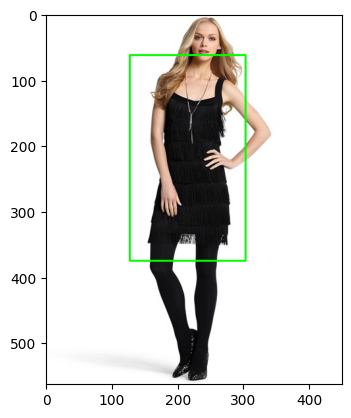

In [256]:
# visually inspect some manually chosen random items
row = subsample.iloc[5000].values
img = cv2.imread('fashion/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(i_w, i_h, x, y, w, h) = row[-6:]
# reconstruct the bboxes
x1 = int((x-w/2)*i_w)
y1 = int((y-h/2)*i_h)
x2 = int((x+w/2)*i_w)
y2 = int((y+h/2)*i_h)
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

# remove files with too much blank space

In [258]:
#!pip install fast_colorthief

In [259]:
import fast_colorthief
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

In [269]:
def excessBlankSpace(file, bbox, sensitivity=5):
    # inspired by: https://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv
    #         and: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    # sensitivity is used to give a range of color space to filter for the background color
    img = cv2.imread(file)

    frm = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    """
        identify area covered by predominant background color within bounding box
    """
    # predominant color
    rgba = cv2.cvtColor(frm, cv2.COLOR_BGR2RGBA)
    crop_rgb = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
    pal = fast_colorthief.get_palette(rgba)
    dominant_color = pal[0]
    
    # area covered by predominant color (maskBgnd)
    lower = np.array(dominant_color)-sensitivity
    upper = np.array(dominant_color)+sensitivity
    maskBgnd = cv2.inRange(crop_rgb, lower, upper)

    # res is calculated to combine with skin masking for visual verification if desired
    maskBgnd_inv = cv2.bitwise_not(maskBgnd)
    bgnd = cv2.bitwise_and(frm, frm, mask=maskBgnd_inv)

    """
        identify area covered by skin tones within bounding box
    """
    hsv = cv2.cvtColor(bgnd, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80]) # found on the internet (one of many)
    upper = np.array([20, 255, 255]) # found on the internet (one of many)
    maskSkin = cv2.inRange(hsv, lower, upper)
    
    # out is calculated and returned for visual verification if desired
    maskSkin_inv = cv2.bitwise_not(maskSkin)    
    out = cv2.bitwise_and(bgnd,bgnd, mask= maskSkin_inv)
    
    #
    # output
    #
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    
    return img, crop_rgb, maskBgnd, maskSkin, out

In [270]:
def plotImg(img, crp, msk, res, bbox):
    fig, ax = plt.subplots(1,4)
    
    # add bbox markup
    (x1, y1, x2, y2) = [int(x) for x in bbox]
    img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    ax[0].imshow(img_bbox)
    ax[1].imshow(crp)
    ax[2].imshow(msk)
    ax[3].imshow(res)
    
    plt.show()

In [271]:
%%time
outsized_bbox_list = []
cnt=0
for i, item in subsample.iterrows():
    if cnt%(int(len(subsample)/10))==0: # because tqdm is not working :(
        print(cnt, len(outsized_bbox_list))
        pass
    cnt+=1
   
    file = 'fashion/'+item.path
    bbox = np.array(item[-10:-6], np.int)
    img, crp, msk1, msk2, res = excessBlankSpace(file, bbox, sensitivity=30)

    # calculate % of bbox occupied by non-desirable 
    # features (predominant background color or skin)
    box_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    msk1_size = msk1[msk1==255].shape
    msk2_size = msk2[msk2==255].shape
    bad_content = max(msk1_size, msk2_size)
    content_ratio = np.round(bad_content[0]/box_size, 2)

    if content_ratio > .8:
        #plotImg(img, crp, msk1, res, bbox) # useful for testing on small sample
        #print(box_size, bad_content[0], bad_ratio) # useful for testing on small sample
        outsized_bbox_list.append(item.path)


0 0


/Users/blairjones/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


6541 65
13082 153
19623 245
26164 352
32705 464
39246 552
45787 665
52328 770
58869 926
65410 1068
CPU times: user 3min 43s, sys: 1min 1s, total: 4min 44s
Wall time: 4min 47s


In [272]:
print('% of images with poor bbox-ing =', round(len(outsized_bbox_list) / len(subsample), 3)*100)

% of images with poor bbox-ing = 1.6


### Identify invalid filenames (those with . in pathname)

In [273]:
to_remove = outsized_bbox_list
for x in subsample.path.values[:]:
    tmp = x.split('.')
    if len(tmp) > 2:
        to_remove.append(x)
to_remove = set(to_remove)
len(to_remove)

1304

In [274]:
subsample = subsample[~subsample.path.isin(to_remove)]
for file in to_remove:
    os.remove('fashion/'+file)
len(subsample)

64110

In [277]:
subsample.groupby('product_type').count()

,index,root_path,product_name,filename,path,x1,y1,x2,y2,i_w,i_h,x,y,w,h
product_type,,,,,,,,,,,,,,,
Dress,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917,12917
Long_Leg,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823,12823
Long_Sleeve,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871,12871
Tank,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852,12852
Tee,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647,12647


### Create label/*.txt and data.yaml files

In [279]:
# create 1 label file for each image
for i, entry in subsample.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = list(cats).index(entry.product_type)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.path.split('.')[0]
    fileroot = 'fashion/labels/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [280]:
lines = []
lines.append('path: ../datasets/fashion # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('fashion/fashion.yaml', 'w')
f.writelines(lines)
f.close()

# Split into Train/Val

In [281]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(subsample, test_size=0.2, random_state=314)

In [282]:
if not os.path.exists('fashion/images'):
    os.mkdir('fashion/images')
if not os.path.exists('fashion/images/train'):
    os.mkdir('fashion/images/train')
if not os.path.exists('fashion/images/val'):
    os.mkdir('fashion/images/val')

if not os.path.exists('fashion/labels'):
    os.mkdir('fashion/labels')
if not os.path.exists('fashion/labels/train'):
    os.mkdir('fashion/labels/train')
if not os.path.exists('fashion/labels/val'):
    os.mkdir('fashion/labels/val')

In [283]:
for i, file in val.iterrows():
    base=file.path
    src = 'fashion/'+base
    dest = 'fashion/images/val/'+base.replace('img_highres/', '')
    folder = 'fashion/images/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(src, dest)
    except:
        print('error on ',src)

    lbl_base = base.split('.')[0]+'.txt'
    lbl_src = 'fashion/labels/'+lbl_base
    lbl_dest = 'fashion/labels/val/'+lbl_base.replace('img_highres/', '')
    folder = 'fashion/labels/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(lbl_src, lbl_dest)
    except:
        print('error on ',src)

# Cleanup remaining paths and create .zip for YOLOv5 training

In [284]:
!mv fashion/img_highres/* fashion/images/train
!rm -r fashion/img_highres

In [285]:
!mv fashion/labels/img_highres/* fashion/labels/train
!rm -r fashion/labels/img_highres

In [289]:
len(subsample) * 2

128220

In [288]:
!find fashion/ -type f | wc -l

  128222


In [290]:
!zip -r -q fashion.zip fashion

# Next

- Load the zip file to the yolov5/pytorch training environment in path datasets/ (to create).
- Unzip the file
- Copy or move the .yaml file to the path yolov5/data/ (expected by train.py from yolov5).  This path is available after running the setup notebook cell which clones the yolov5 repo.